# Machine Learning para Previsão de Alta/Baixa do IBOVESPA

A previsão de movimentos em mercados financeiros é uma das tarefas mais desafiadoras no campo da ciência de dados e finanças quantitativas. A Hipótese do Mercado Eficiente (HME), em sua forma fraca, postula que todos os preços históricos já estão refletidos no preço atual de um ativo, tornando a análise de dados passados, por si só, insuficiente para gerar retornos anormais de forma consistente.

O objetivo não é construir um oráculo infalível, mas sim desenvolver um modelo de machine learning que forneça uma vantagem estatística, mesmo que marginal, na previsão da direção diária do Índice Bovespa (IBOVESPA).



É fundamental estabelecer expectativas realistas desde o início. A natureza caótica, dinâmica e não linear dos mercados financeiros significa que a previsão perfeita é uma impossibilidade teórica e prática. Um modelo que demonstre um desempenho consistentemente superior ao acaso (por exemplo, uma acurácia de 55% com um F1-score equilibrado em dados fora da amostra) já pode ser considerado valioso e potencialmente explorável em uma estratégia de negociação quantitativa.

--------------------------------------------------------------------------------------------------------------
## Seção 1: Integridade dos Dados e Análise Exploratória

A fase inicial de qualquer projeto de modelagem é a mais crítica. Erros ou mal-entendidos nesta etapa se propagarão por todo o fluxo de trabalho, comprometendo a validade dos resultados finais.

Imports

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuração para gráficos
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")


caminho_arquivo = 'dados_ibovespa_exemplo.csv'

1.1 - Carregamento e Validação Inicial dos Dados

In [164]:
def carregar_e_validar_dados(caminho_arquivo):
    """
    EAP 1.1.1, 1.1.2, 1.1.3 - Carregamento, conversão de data e verificação de integridade
    """
    print("=" * 60)
    print("EAP 1.1 - AQUISIÇÃO E VALIDAÇÃO INICIAL")
    print("=" * 60)
    
    # 1.1.1 - Carregar o dataset
    print("Carregando dados...")
    dados = pd.read_csv(caminho_arquivo)
    print(f"Dados carregados: {len(dados)} registros")
    print(f"Colunas: {list(dados.columns)}")
    
    # 1.1.2 - Converter data para datetime e definir como índice
    print("\n Convertendo data para índice...")
    
    # Identifica coluna de data
    colunas_data = [col for col in dados.columns if 'date' in col.lower()]
    if colunas_data:
        coluna_data = colunas_data[0]
    else:
        coluna_data = dados.columns[0]  # Assume primeira coluna
    
    dados[coluna_data] = pd.to_datetime(dados[coluna_data])
    dados.set_index(coluna_data, inplace=True)
    print(f"✓ Data convertida e definida como índice")
    print(f"✓ Período: {dados.index.min()} até {dados.index.max()}")
    
    # 1.1.3 - Verificação de integridade
    print("\nVerificando integridade dos dados...")
    
    # Duplicatas
    duplicatas_indice = dados.index.duplicated().sum()
    duplicatas_linhas = dados.duplicated().sum()
    
    # Consistência OHLC
    inconsistencias = 0
    if all(col in dados.columns for col in ['High', 'Low', 'Close']):
        inconsistencias_high = (dados['High'] < dados['Close']).sum()
        inconsistencias_low = (dados['Low'] > dados['Close']).sum()
        inconsistencias = inconsistencias_high + inconsistencias_low
    
    # Valores nulos
    valores_nulos = dados.isnull().sum()
    
    print(f"Duplicatas no índice: {duplicatas_indice}")
    print(f"Duplicatas em linhas: {duplicatas_linhas}")
    print(f"Inconsistências OHLC: {inconsistencias}")
    print(f"Valores nulos por coluna:")
    for coluna, nulos in valores_nulos.items():
        if nulos > 0:
            print(f"   - {coluna}: {nulos}")
    
    return dados

def carregar_e_validar_dados(caminho_arquivo):
    """
    EAP 1.1.1, 1.1.2, 1.1.3 - Carregamento, conversão de data e verificação de integridade
    """
    print("=" * 60)
    print("EAP 1.1 - AQUISIÇÃO E VALIDAÇÃO INICIAL")
    print("=" * 60)
    
    # 1.1.1 - Carregar o dataset
    print("Carregando dados...")
    dados = pd.read_csv(caminho_arquivo)
    print(f"Dados carregados: {len(dados)} registros")
    print(f"Colunas: {list(dados.columns)}")
    
    # 1.1.2 - Converter data para datetime e definir como índice
    print("\n Convertendo data para índice...")
    
    # Identifica coluna de data
    colunas_data = [col for col in dados.columns if 'date' in col.lower()]
    if colunas_data:
        coluna_data = colunas_data[0]
    else:
        coluna_data = dados.columns[0]  # Assume primeira coluna
    
    dados[coluna_data] = pd.to_datetime(dados[coluna_data])
    dados.set_index(coluna_data, inplace=True)
    print(f"✓ Data convertida e definida como índice")
    print(f"✓ Período: {dados.index.min()} até {dados.index.max()}")
    
    # 1.1.3 - Verificação de integridade
    print("\nVerificando integridade dos dados...")
    
    # Duplicatas
    duplicatas_indice = dados.index.duplicated().sum()
    duplicatas_linhas = dados.duplicated().sum()
    
    # Consistência OHLC
    inconsistencias = 0
    if all(col in dados.columns for col in ['High', 'Low', 'Close']):
        inconsistencias_high = (dados['High'] < dados['Close']).sum()
        inconsistencias_low = (dados['Low'] > dados['Close']).sum()
        inconsistencias = inconsistencias_high + inconsistencias_low
    
    # Valores nulos
    valores_nulos = dados.isnull().sum()
    
    print(f"Duplicatas no índice: {duplicatas_indice}")
    print(f"Duplicatas em linhas: {duplicatas_linhas}")
    print(f"Inconsistências OHLC: {inconsistencias}")
    print(f"Valores nulos por coluna:")
    for coluna, nulos in valores_nulos.items():
        if nulos > 0:
            print(f"   - {coluna}: {nulos}")
    
    return dados

1.2 - Limpeza e Tratamento dos Dados

In [165]:
def limpar_e_tratar_dados(dados):
    """
    EAP 1.2.1, 1.2.3 - Identificação de lacunas e documentação de outliers.
    O preenchimento com forward fill foi REMOVIDO para operar apenas com dias de pregão.
    """
    print("\n" + "=" * 60)
    print("EAP 1.2 - LIMPEZA E TRATAMENTO DE DADOS")
    print("=" * 60)
    
    # 1.2.1 - Identificar lacunas na série temporal (APENAS PARA ANÁLISE)
    print("Analisando lacunas temporais (sem alterar os dados)...")
    
    inicio = dados.index.min()
    fim = dados.index.max()
    todas_datas = pd.date_range(start=inicio, end=fim, freq='D')
    datas_ausentes = todas_datas.difference(dados.index)
    
    # Classifica lacunas
    fins_semana = datas_ausentes[datas_ausentes.weekday >= 5]
    dias_uteis_ausentes = datas_ausentes[datas_ausentes.weekday < 5]
    
    print(f"Total de datas ausentes no calendário: {len(datas_ausentes)}")
    print(f"-> Sendo {len(fins_semana)} fins de semana.")
    print(f"-> E {len(dias_uteis_ausentes)} dias úteis (feriados).")
    
    # 1.2.2 - Bloco de forward fill REMOVIDO
    print("\nAVISO: O preenchimento com forward fill foi desativado.")
    print("O modelo operará apenas com os dados dos dias de pregão reais.")
    print(f"Mantendo os {len(dados)} registros originais.")
    
    # 1.2.3 - Documentar decisão sobre outliers
    print("\nDocumentando decisão sobre outliers...")
    print("""
    DECISÃO: NÃO REMOVER OUTLIERS
    
    JUSTIFICATIVA:
    • Outliers em dados financeiros representam eventos legítimos de mercado
    • Movimentos extremos contêm informação valiosa sobre volatilidade
    • Modelos baseados em árvores (XGBoost) são robustos a outliers
    • Manter outliers garante realismo na modelagem
    """)
    
    # Retorna o dataframe original, sem preenchimento.
    return dados

1.3.1 - Estatísticas Descritivas

In [166]:
def gerar_estatisticas_descritivas(dados):
    """
    EAP 1.3.1 - Gerar e analisar estatísticas descritivas
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.1 - ESTATÍSTICAS DESCRITIVAS")
    print("=" * 60)
    
    stats_desc = dados.describe()
    print("Estatísticas Descritivas:")
    print(stats_desc)
    
    print("\nCoeficientes de Variação:")
    for coluna in dados.select_dtypes(include=[np.number]).columns:
        cv = dados[coluna].std() / dados[coluna].mean()
        print(f"✓ {coluna}: {cv:.4f}")
    
    return stats_desc

1.3.2 - Gráficos de Preço e Volume

In [167]:
def plotar_preco_e_volume(dados, salvar_grafico=True):
    """
    EAP 1.3.2 - Plotar gráfico de preço de fechamento e volume ao longo do tempo
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.2 - GRÁFICOS DE PREÇO E VOLUME")
    print("=" * 60)

    # Identifica colunas com base nos nomes reais do arquivo
    col_close = 'Último'  # Nome exato da coluna
    col_volume = 'Vol.'   # Nome exato da coluna

    # Criar subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Gráfico de preço
    ax1.plot(dados.index, dados[col_close], linewidth=1, color='blue', alpha=0.8)
    ax1.set_title('IBOVESPA - Preço de Fechamento ao Longo do Tempo', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Preço de Fechamento', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Formatação do eixo Y para preços
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

    # FUNÇÃO PARA CONVERTER VOLUME
    def converter_volume_seguro(vol_str):
        try:
            if pd.isna(vol_str) or vol_str == '-' or vol_str == '': 
                return np.nan
            vol_str = str(vol_str).replace(',', '.')
            if 'B' in vol_str: 
                return float(vol_str.replace('B', '')) * 1e9
            elif 'M' in vol_str: 
                return float(vol_str.replace('M', '')) * 1e6
            elif 'K' in vol_str: 
                return float(vol_str.replace('K', '')) * 1e3
            return float(vol_str)
        except:
            return np.nan
    
    # Converter volume para numérico
    print("Convertendo dados de volume...")
    volume_numerico = dados[col_volume].apply(converter_volume_seguro)
    
    # Dividir por 1e9 para mostrar em bilhões
    volume_bilhoes = volume_numerico / 1e9

    # Plotar volume
    ax2.fill_between(dados.index, volume_bilhoes, alpha=0.7, color='orange')
    ax2.plot(dados.index, volume_bilhoes, linewidth=0.5, color='darkorange')

    ax2.set_title('IBOVESPA - Volume de Negociação ao Longo do Tempo', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Volume (Bilhões)', fontsize=12)
    ax2.set_xlabel('Data', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    # Formatação do eixo Y para volume
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}B'))

    # Estatísticas do volume
    volume_valido = volume_numerico.dropna()
    if len(volume_valido) > 0:
        print(f"Volume médio: {volume_valido.mean()/1e9:.2f} bilhões")
        print(f"Volume mínimo: {volume_valido.min()/1e9:.2f} bilhões")
        print(f"Volume máximo: {volume_valido.max()/1e9:.2f} bilhões")

    plt.tight_layout()

    if salvar_grafico:
        plt.savefig('grafico_preco_volume.png', dpi=300, bbox_inches='tight')
        print("Gráfico salvo como 'grafico_preco_volume.png'")

    plt.show()
    print("Gráficos de preço e volume gerados")

1.3.3 - Calcular Retornos Logarítmicos Diários

In [168]:
def calcular_retornos_logaritmicos(dados):
    """
    EAP 1.3.3 - Calcular retornos logarítmicos diários
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.3 - RETORNOS LOGARÍTMICOS")
    print("=" * 60)

    # Identifica coluna de fechamento com base no nome real
    col_close = 'Último' 
    

    print(f"Usando coluna de fechamento: {col_close}")

    # Calcula retornos logarítmicos
    retornos = np.log(dados[col_close] / dados[col_close].shift(1))
    retornos = retornos.dropna()

    # Adiciona aos dados
    dados['Retornos_Log'] = np.log(dados[col_close] / dados[col_close].shift(1))

    print(f"Retornos calculados: {len(retornos)} observações")
    print(f"Estatísticas dos retornos:")
    print(f"   - Média: {retornos.mean():.6f}")
    print(f"   - Desvio Padrão: {retornos.std():.6f}")
    print(f"   - Mínimo: {retornos.min():.6f}")
    print(f"   - Máximo: {retornos.max():.6f}")
    print(f"   - Assimetria: {retornos.skew():.6f}")
    print(f"   - Curtose: {retornos.kurtosis():.6f}")

    return dados, retornos

1.3.4 - Análise da Distribuição dos Retornos

In [169]:
def analisar_distribuicao_retornos(retornos, salvar_grafico=True):
    """
    EAP 1.3.4 - Plotar histograma dos retornos e analisar distribuição
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.4 - ANÁLISE DA DISTRIBUIÇÃO DOS RETORNOS")
    print("=" * 60)

    # Cria gráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Histograma
    ax1.hist(retornos, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title('Distribuição dos Retornos Logarítmicos Diários', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Retornos Logarítmicos', fontsize=12)
    ax1.set_ylabel('Densidade', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Curva normal para comparação
    mu, sigma = retornos.mean(), retornos.std()
    x = np.linspace(retornos.min(), retornos.max(), 100)
    normal_curve = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    ax1.plot(x, normal_curve, 'r-', linewidth=2, label='Distribuição Normal')
    ax1.legend()

    # Q-Q plot
    stats.probplot(retornos, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot: Retornos vs Distribuição Normal', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if salvar_grafico:
        plt.savefig('histograma_retornos.png', dpi=300, bbox_inches='tight')
        print("Gráfico salvo como 'histograma_retornos.png'")

    plt.show()

    # Análise estatística
    print("Análise da Distribuição:")
    print(f"Curtose: {retornos.kurtosis():.4f} (Normal = 0)")
    if retornos.kurtosis() > 0:
        print("   → Distribuição leptocúrtica (caudas gordas)")
    else:
        print("   → Distribuição platicúrtica (caudas finas)")

    print(f"Assimetria: {retornos.skew():.4f} (Normal = 0)")
    if abs(retornos.skew()) > 0.5:
        print("   → Distribuição assimétrica")
    else:
        print("   → Distribuição aproximadamente simétrica")

    # Teste de normalidade
    from scipy.stats import jarque_bera
    jb_stat, jb_pvalue = jarque_bera(retornos)
    print(f"Teste Jarque-Bera: estatística={jb_stat:.4f}, p-valor={jb_pvalue:.6f}")
    if jb_pvalue < 0.05:
        print("   → Rejeita hipótese de normalidade (p < 0.05)")
    else:
        print("   → Não rejeita hipótese de normalidade (p >= 0.05)")

1.3.5 - Análise de Volatility Clustering

In [170]:
def analisar_volatility_clustering(retornos, salvar_grafico=True):
    """
    EAP 1.3.5 - Plotar série de retornos para identificar volatility clustering
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.5 - ANÁLISE DE VOLATILITY CLUSTERING")
    print("=" * 60)

    # Cria gráficos
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Série temporal dos retornos
    ax1.plot(retornos.index, retornos, linewidth=0.8, color='darkblue', alpha=0.8)
    ax1.set_title('IBOVESPA - Retornos Logarítmicos Diários ao Longo do Tempo',
                 fontsize=14, fontweight='bold')
    ax1.set_ylabel('Retornos Logarítmicos', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)

    # Volatilidade móvel (desvio padrão móvel de 30 dias)
    volatilidade_movel = retornos.rolling(window=30).std()
    ax2.plot(volatilidade_movel.index, volatilidade_movel,
            linewidth=1.5, color='orange', alpha=0.8)
    ax2.set_title('Volatilidade Móvel (30 dias) - Evidência de Agrupamento de Volatilidade',
                 fontsize=14, fontweight='bold')
    ax2.set_ylabel('Volatilidade (Desvio Padrão)', fontsize=12)
    ax2.set_xlabel('Data', fontsize=12)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if salvar_grafico:
        plt.savefig('serie_retornos_volatilidade.png', dpi=300, bbox_inches='tight')
        print("Gráfico salvo como 'serie_retornos_volatilidade.png'")

    plt.show()


Execução da Fase 1

EXECUÇÃO COMPLETA DA FASE 1
EAP 1.1 - AQUISIÇÃO E VALIDAÇÃO INICIAL
Carregando dados...
Dados carregados: 3592 registros
Colunas: ['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']

 Convertendo data para índice...
✓ Data convertida e definida como índice
✓ Período: 2011-01-03 00:00:00 até 2025-06-30 00:00:00

Verificando integridade dos dados...
Duplicatas no índice: 0
Duplicatas em linhas: 0
Inconsistências OHLC: 0
Valores nulos por coluna:
   - Vol.: 1

EAP 1.2 - LIMPEZA E TRATAMENTO DE DADOS
Analisando lacunas temporais (sem alterar os dados)...
Total de datas ausentes no calendário: 1701
-> Sendo 1512 fins de semana.
-> E 189 dias úteis (feriados).

AVISO: O preenchimento com forward fill foi desativado.
O modelo operará apenas com os dados dos dias de pregão reais.
Mantendo os 3592 registros originais.

Documentando decisão sobre outliers...

    DECISÃO: NÃO REMOVER OUTLIERS

    JUSTIFICATIVA:
    • Outliers em dados financeiros representam eventos legítimos de 

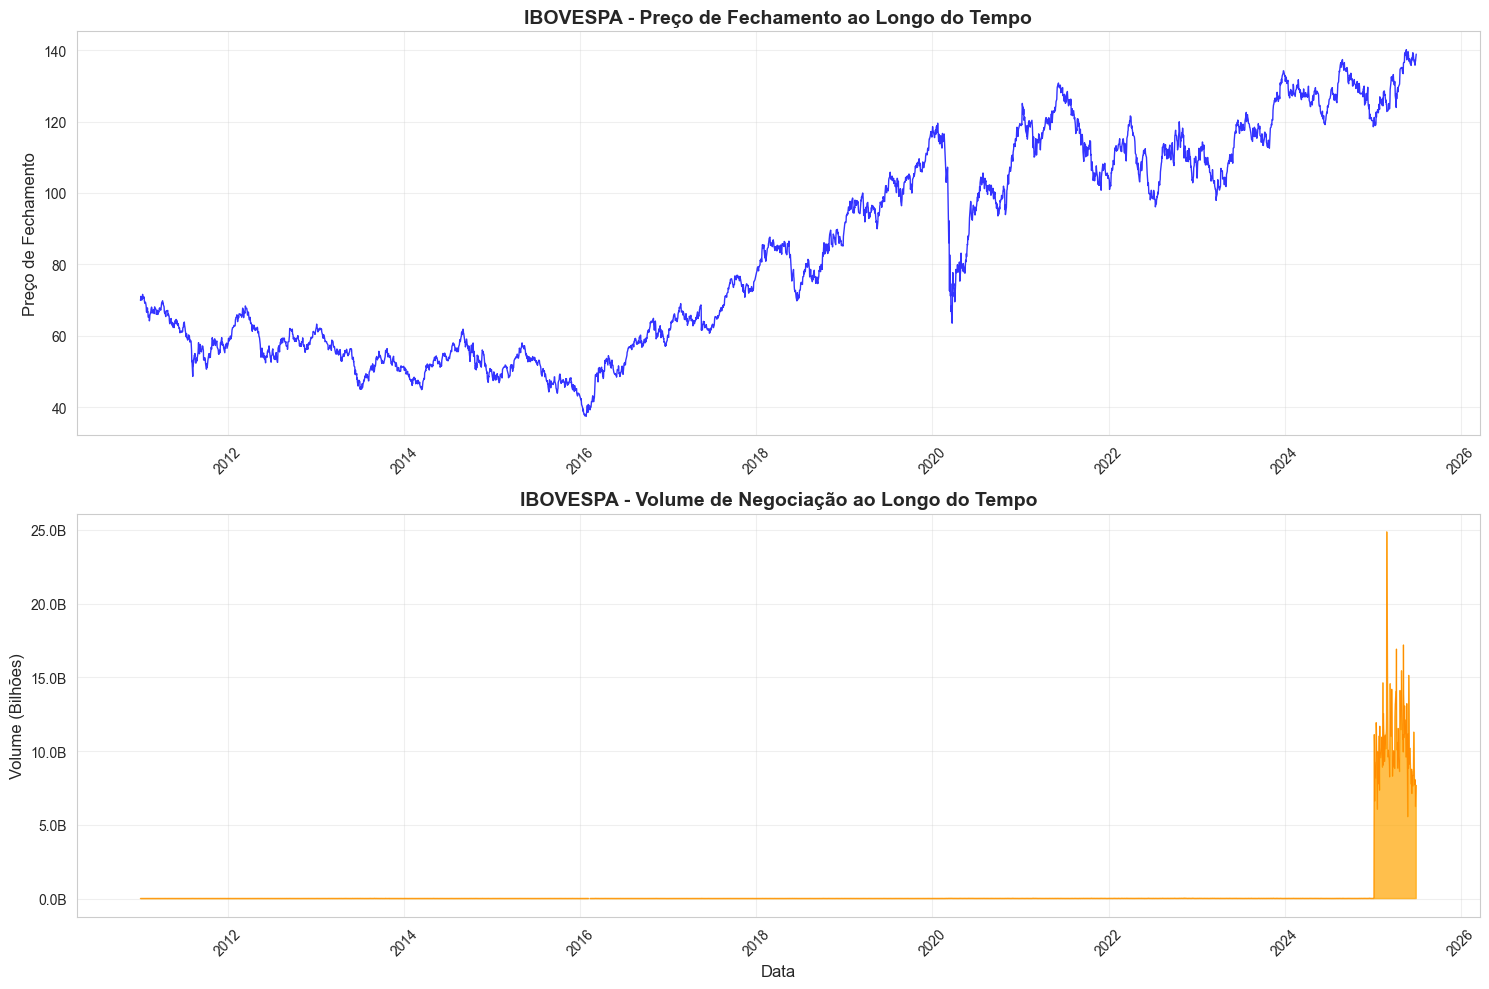

Gráficos de preço e volume gerados

EAP 1.3.3 - RETORNOS LOGARÍTMICOS
Usando coluna de fechamento: Último
Retornos calculados: 3591 observações
Estatísticas dos retornos:
   - Média: -0.000191
   - Desvio Padrão: 0.014896
   - Mínimo: -0.130223
   - Máximo: 0.159930
   - Assimetria: 0.798093
   - Curtose: 12.271309

EAP 1.3.4 - ANÁLISE DA DISTRIBUIÇÃO DOS RETORNOS
Gráfico salvo como 'histograma_retornos.png'


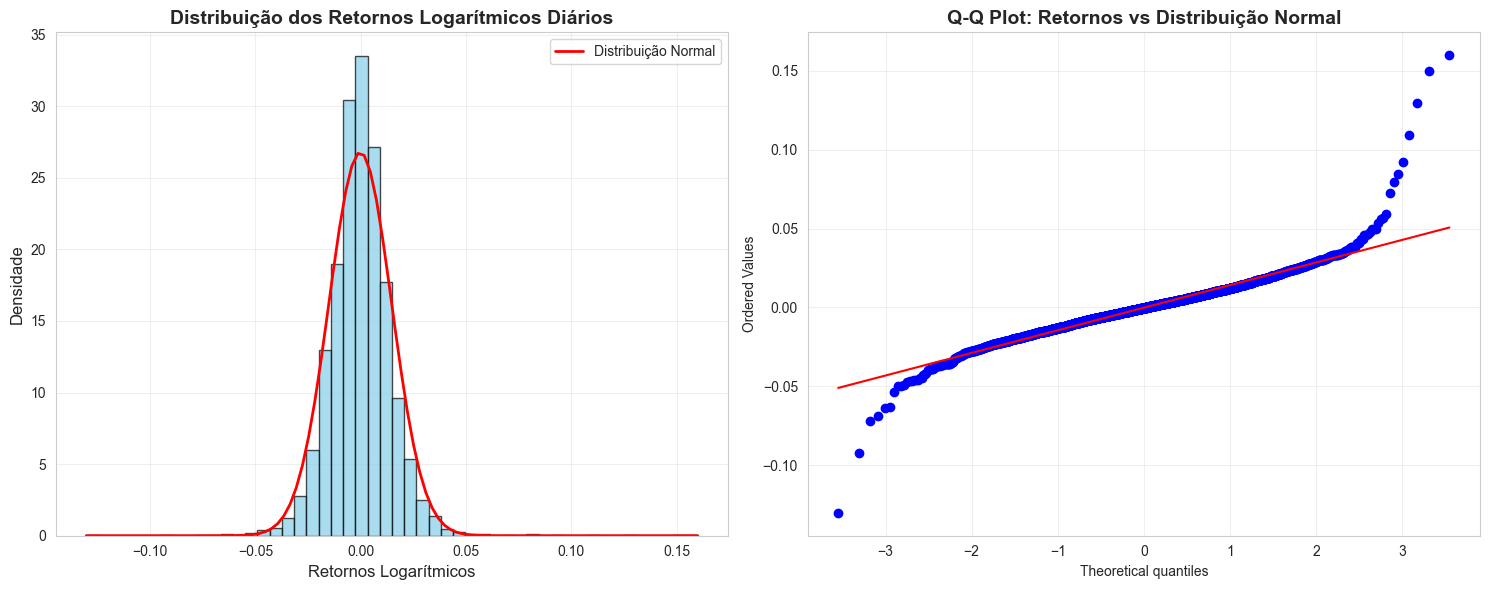

Análise da Distribuição:
Curtose: 12.2713 (Normal = 0)
   → Distribuição leptocúrtica (caudas gordas)
Assimetria: 0.7981 (Normal = 0)
   → Distribuição assimétrica
Teste Jarque-Bera: estatística=22843.3807, p-valor=0.000000
   → Rejeita hipótese de normalidade (p < 0.05)

EAP 1.3.5 - ANÁLISE DE VOLATILITY CLUSTERING
Gráfico salvo como 'serie_retornos_volatilidade.png'


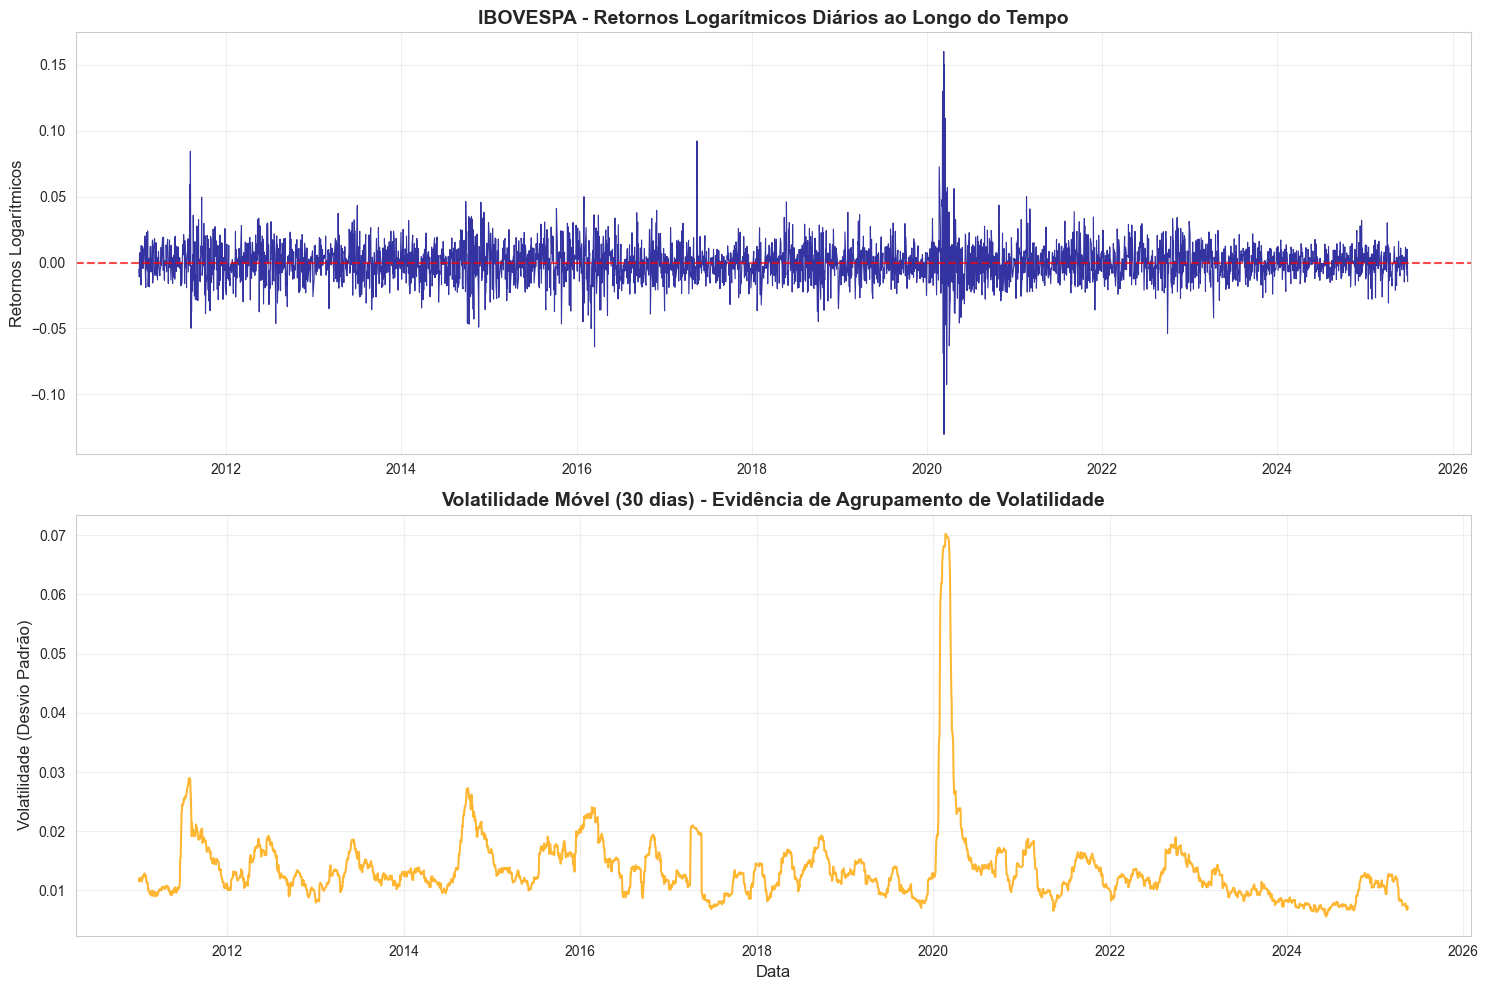

In [171]:
def executar_fase_1_completa(caminho_arquivo):
    """
    Executa toda a Fase 1 do EAP de forma sequencial
    """
    print("=" * 80)
    print("EXECUÇÃO COMPLETA DA FASE 1")
    print("=" * 80)

    try:
        # Executa todos os blocos sequencialmente
        dados = carregar_e_validar_dados(caminho_arquivo)
        dados_limpos = limpar_e_tratar_dados(dados)
        stats = gerar_estatisticas_descritivas(dados_limpos)
        plotar_preco_e_volume(dados_limpos)
        dados_com_retornos, retornos = calcular_retornos_logaritmicos(dados_limpos)
        analisar_distribuicao_retornos(retornos)
        analisar_volatility_clustering(retornos)


        return dados_com_retornos, {'stats': stats}

    except Exception as e:
        print(f"\nERRO NA EXECUÇÃO: {str(e)}")
        raise


dados, resultados = executar_fase_1_completa('dados_bovespa.csv')

Fase 1 Completa!

--------------------------------------------------------------------------------------------------------------
## Seção 2: Definição do Alvo e Engenharia de Atributos

A fase de engenharia de atributos é onde a "inteligência" do nosso modelo é realmente criada. A qualidade das variáveis que geramos aqui define o potencial máximo de acerto do projeto. Um erro simples nesta etapa, como usar dados do futuro para criar um indicador, pode criar um modelo que parece ótimo nos testes, mas que não funciona na vida real.


## Imports

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette('husl')

## Carregamento dos Dados

## Funções Auxiliares

Implementação manual dos indicadores técnicos:

In [173]:
def calcular_sma(serie, periodo):
    """
    Calcula a Média Móvel Simples (SMA)
    Compatível com NumPy 2.0+
    """
    return serie.rolling(window=periodo, min_periods=periodo).mean()

def calcular_retornos_log(serie):
    """
    Calcula retornos logarítmicos
    Compatível com NumPy 2.0+
    """
    return np.log(serie / serie.shift(1))

def criar_lags_retornos(retornos, max_lag=5):
    """
    Cria lags dos retornos
    Compatível com NumPy 2.0+
    """
    lags = {}
    for lag in range(1, max_lag + 1):
        lags[f'Return_Lag_{lag}'] = retornos.shift(lag)
    return lags

## Carregamento dos Dados

In [174]:
# Carrega os dados limpos da Fase 1

print(f'Dados carregados: {len(dados)} registros')
print(f'Período: {dados.index.min()} a {dados.index.max()}')
print(f'Colunas: {list(dados.columns)}')

# Visualiza as primeiras linhas
print('\n=== PRIMEIRAS LINHAS DOS DADOS ===')
dados.head()

Dados carregados: 3592 registros
Período: 2011-01-03 00:00:00 a 2025-06-30 00:00:00
Colunas: ['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'Retornos_Log']

=== PRIMEIRAS LINHAS DOS DADOS ===


,Último,Abertura,Máxima,Mínima,Vol.,Var%,Retornos_Log
Data,,,,,,,
2025-06-30,138.855,136.865,139.103,136.430,"7,68B","1,45%",NaN
2025-06-27,136.866,137.113,137.209,136.469,"6,24B","-0,18%",-0.014428
2025-06-26,137.114,135.767,137.353,135.756,"8,02B","0,99%",0.001810
2025-06-25,135.767,137.163,137.163,135.565,"7,71B","-1,02%",-0.009873
2025-06-24,137.165,136.552,138.156,136.254,"8,08B","0,45%",0.010244


## Criação da Variável Alvo (Target)

Criei a variável alvo:
- **Target = 1** se Close(t+1) > Close(t)
- **Target = 0** caso contrário

In [175]:
# Copia os dados para não modificar o original
dados_com_target = dados.copy()
col_close = 'Último'

# Cria a variável alvo
close_amanha = dados_com_target[col_close].shift(-1)
close_hoje = dados_com_target[col_close]
dados_com_target['Target'] = (close_amanha > close_hoje).astype(int)

# Remove a última linha que contém NaN no Target
dados_com_target = dados_com_target.dropna(subset=['Target'])

print('\n=== CRIAÇÃO DA VARIÁVEL ALVO ===')
print('Variável Target criada com sucesso')
print('Lógica: Target = 1 se Close(t+1) > Close(t), 0 caso contrário')
print(f'Registros após remoção de NaN: {len(dados_com_target)}')

# Visualiza os primeiros registros com o target
print('\n=== PRIMEIROS REGISTROS COM TARGET ===')
dados_com_target[['Abertura', 'Máxima', 'Mínima', 'Último', 'Target']].head(10)


=== CRIAÇÃO DA VARIÁVEL ALVO ===
Variável Target criada com sucesso
Lógica: Target = 1 se Close(t+1) > Close(t), 0 caso contrário
Registros após remoção de NaN: 3592

=== PRIMEIROS REGISTROS COM TARGET ===


,Abertura,Máxima,Mínima,Último,Target
Data,,,,,
2025-06-30,136.865,139.103,136.430,138.855,0
2025-06-27,137.113,137.209,136.469,136.866,1
2025-06-26,135.767,137.353,135.756,137.114,0
2025-06-25,137.163,137.163,135.565,135.767,1
2025-06-24,136.552,138.156,136.254,137.165,0
2025-06-23,137.116,137.130,135.835,136.551,1
2025-06-20,138.715,138.719,136.815,137.116,1
2025-06-18,138.844,139.161,138.443,138.717,1
2025-06-17,139.256,139.497,138.293,138.840,1


## Análise da Distribuição de Classes

=== ANÁLISE DA DISTRIBUIÇÃO DE CLASSES ===
✓ Distribuição absoluta:
   - Classe 0: 1836 (51.11%)
   - Classe 1: 1756 (48.89%)

✓ Análise de desbalanceamento:
   - Classe majoritária: 0 (51.11%)
   - Razão de desbalanceamento: 1.05:1
   - Status: BALANCEADO (razão <= 1.5)


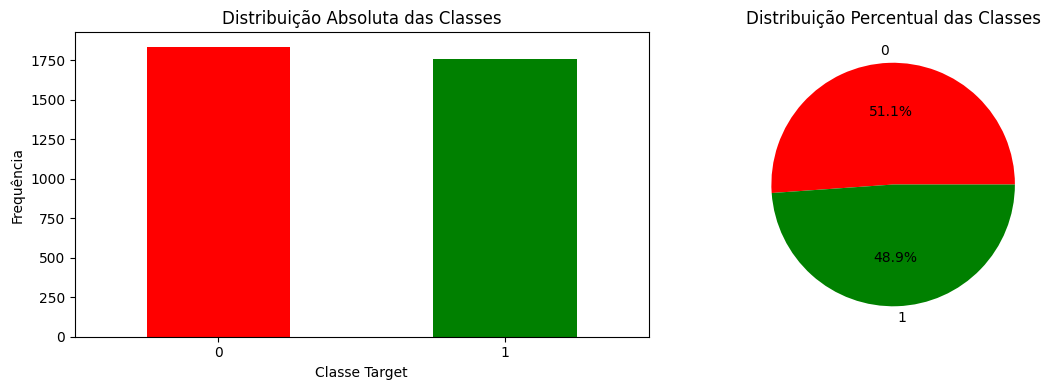

In [176]:
# Calcula e analisa a frequência das classes 0 e 1
distribuicao = dados_com_target['Target'].value_counts()
proporcoes = dados_com_target['Target'].value_counts(normalize=True)

# Análise de desbalanceamento
classe_majoritaria = proporcoes.idxmax()
prop_majoritaria = proporcoes.max()
prop_minoritaria = proporcoes.min()
razao_desbalanceamento = prop_majoritaria / prop_minoritaria

print('=== ANÁLISE DA DISTRIBUIÇÃO DE CLASSES ===')
print('✓ Distribuição absoluta:')
for classe, count in distribuicao.items():
    print(f'   - Classe {classe}: {count} ({proporcoes[classe]:.2%})')

print('\n✓ Análise de desbalanceamento:')
print(f'   - Classe majoritária: {classe_majoritaria} ({prop_majoritaria:.2%})')
print(f'   - Razão de desbalanceamento: {razao_desbalanceamento:.2f}:1')

if razao_desbalanceamento > 1.5:
    print('   - Status: DESBALANCEADO (razão > 1.5)')
    print('   - Implicações:')
    print('     • Acurácia não é uma métrica confiável')
    print('     • Usar Precisão, Recall e F1-Score')
    print('     • Considerar scale_pos_weight no XGBoost')
else:
    print('   - Status: BALANCEADO (razão <= 1.5)')

# Visualização gráfica
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras
distribuicao.plot(kind='bar', ax=ax1, color=['red', 'green'])
ax1.set_title('Distribuição Absoluta das Classes')
ax1.set_xlabel('Classe Target')
ax1.set_ylabel('Frequência')
ax1.tick_params(axis='x', rotation=0)

# Gráfico de pizza
proporcoes.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=['red', 'green'])
ax2.set_title('Distribuição Percentual das Classes')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## Engenharia de Atributos

### Atributos de Momento (Lags de Retornos)

In [177]:
# Copia os dados com target para adicionar features
dados_com_features = dados_com_target.copy()

# Calcula retornos logarítmicos usando função manual
dados_com_features['Retornos_Log'] = calcular_retornos_log(dados_com_features[col_close])

# Dicionário para armazenar informações dos atributos criados
dicionario_atributos = {}

# Cria lags dos retornos (1 a 5 dias)
print('=== CRIANDO ATRIBUTOS DE MOMENTO ===')
print('Usando implementação manual')

lags_retornos = criar_lags_retornos(dados_com_features['Retornos_Log'], 5)
for col_name, serie_lag in lags_retornos.items():
    dados_com_features[col_name] = serie_lag
    lag_num = col_name.split('_')[-1]
    
    # Adiciona ao dicionário de atributos
    dicionario_atributos[col_name] = {
        'calculo': f'log(Close(t-{lag_num}) / Close(t-{lag_num}-1))',
        'dados_entrada': 'Close',
        'intuicao_financeira': f'Captura o momentum de {lag_num} dia(s) atrás',
        'categoria': 'Momento'
    }
    print(f'Criado: {col_name}')

print('\nAtributos de momento criados com sucesso!')
print('Capturam informações de momentum de curto prazo')

# Visualiza os novos atributos
colunas_momento = [f'Return_Lag_{i}' for i in range(1, 6)]
print('\n=== PRIMEIROS REGISTROS COM ATRIBUTOS DE MOMENTO ===')
dados_com_features[['Último', 'Retornos_Log'] + colunas_momento + ['Target']].head(10)

=== CRIANDO ATRIBUTOS DE MOMENTO ===
Usando implementação manual
Criado: Return_Lag_1
Criado: Return_Lag_2
Criado: Return_Lag_3
Criado: Return_Lag_4
Criado: Return_Lag_5

Atributos de momento criados com sucesso!
Capturam informações de momentum de curto prazo

=== PRIMEIROS REGISTROS COM ATRIBUTOS DE MOMENTO ===


,Último,Retornos_Log,Return_Lag_1,Return_Lag_2,Return_Lag_3,Return_Lag_4,Return_Lag_5,Target
Data,,,,,,,,
2025-06-30,138.855,NaN,NaN,NaN,NaN,NaN,NaN,0
2025-06-27,136.866,-0.014428,NaN,NaN,NaN,NaN,NaN,1
2025-06-26,137.114,0.001810,-0.014428,NaN,NaN,NaN,NaN,0
2025-06-25,135.767,-0.009873,0.001810,-0.014428,NaN,NaN,NaN,1
2025-06-24,137.165,0.010244,-0.009873,0.001810,-0.014428,NaN,NaN,0
2025-06-23,136.551,-0.004486,0.010244,-0.009873,0.001810,-0.014428,NaN,1
2025-06-20,137.116,0.004129,-0.004486,0.010244,-0.009873,0.001810,-0.014428,1
2025-06-18,138.717,0.011609,0.004129,-0.004486,0.010244,-0.009873,0.001810,1
2025-06-17,138.840,0.000886,0.011609,0.004129,-0.004486,0.010244,-0.009873,1


### Atributos de Tendência (SMAs e Ratios)

In [178]:
# Cria médias móveis simples usando função manual
periodos_sma = [5, 10, 20]


for periodo in periodos_sma:
    col_name = f'SMA_{periodo}'
    dados_com_features[col_name] = calcular_sma(dados_com_features[col_close], periodo)
    
    # Adiciona ao dicionário de atributos
    dicionario_atributos[col_name] = {
        'calculo': f'Média móvel simples de {periodo} períodos',
        'dados_entrada': 'Close',
        'intuicao_financeira': f'Tendência de {"curto" if periodo <= 10 else "médio"} prazo',
        'categoria': 'Tendência'
    }

# Cria ratios entre preço e SMAs

for periodo in periodos_sma:
    col_name = f'Close_SMA_{periodo}_Ratio'
    dados_com_features[col_name] = dados_com_features[col_close] / dados_com_features[f'SMA_{periodo}']
    
    # Adiciona ao dicionário de atributos
    dicionario_atributos[col_name] = {
        'calculo': f'Close / SMA_{periodo}',
        'dados_entrada': 'Close, SMA',
        'intuicao_financeira': f'Posição relativa do preço vs tendência de {periodo} dias',
        'categoria': 'Tendência'
    }

# Cria ratios entre SMAs
dados_com_features['SMA_5_10_Ratio'] = dados_com_features['SMA_5'] / dados_com_features['SMA_10']
dados_com_features['SMA_10_20_Ratio'] = dados_com_features['SMA_10'] / dados_com_features['SMA_20']

# Adiciona ao dicionário
dicionario_atributos['SMA_5_10_Ratio'] = {
    'calculo': 'SMA_5 / SMA_10',
    'dados_entrada': 'SMA_5, SMA_10',
    'intuicao_financeira': 'Divergência entre tendências de curto e médio prazo',
    'categoria': 'Tendência'
}

dicionario_atributos['SMA_10_20_Ratio'] = {
    'calculo': 'SMA_10 / SMA_20',
    'dados_entrada': 'SMA_10, SMA_20',
    'intuicao_financeira': 'Divergência entre tendências de médio prazo',
    'categoria': 'Tendência'
}

## Finalização e Limpeza dos Dados

In [179]:
# Remove registros com NaN (causados pelos lags e médias móveis)
dados_finais = dados_com_features.dropna()

print('=== FINALIZAÇÃO DOS DADOS ===')
print(f'Registros antes da limpeza: {len(dados_com_features)}')
print(f'Registros após limpeza: {len(dados_finais)}')
print(f'Registros removidos: {len(dados_com_features) - len(dados_finais)}')
print(f'Total de colunas: {len(dados_finais.columns)}')

# Lista todas as colunas criadas
colunas_originais = dados.columns.tolist()
colunas_criadas = [col for col in dados_finais.columns if col not in colunas_originais]

print(f'\nColunas criadas ({len(colunas_criadas)}): {colunas_criadas}')

# Verifica distribuição final do target
distribuicao_final = dados_finais['Target'].value_counts(normalize=True)
print(f'\nDistribuição final do Target:')
for classe, prop in distribuicao_final.items():
    print(f'   - Classe {classe}: {prop:.2%}')

# Salva os dados processados
dados_finais.to_csv('dados_fase2_completos.csv')
print(f'\nDados salvos em: dados_fase2_completos.csv')

# Salva o dicionário de atributos
with open('dicionario_atributos_fase2.json', 'w', encoding='utf-8') as f:
    json.dump(dicionario_atributos, f, indent=2, ensure_ascii=False)
print(f'Dicionário salvo em: dicionario_atributos_fase2.json')

# Visualiza o dataset final
print('\n=== DATASET FINAL ===')
dados_finais.head()

=== FINALIZAÇÃO DOS DADOS ===
Registros antes da limpeza: 3592
Registros após limpeza: 3572
Registros removidos: 20
Total de colunas: 21

Colunas criadas (14): ['Target', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5', 'SMA_5', 'SMA_10', 'SMA_20', 'Close_SMA_5_Ratio', 'Close_SMA_10_Ratio', 'Close_SMA_20_Ratio', 'SMA_5_10_Ratio', 'SMA_10_20_Ratio']

Distribuição final do Target:
   - Classe 0: 51.18%
   - Classe 1: 48.82%

Dados salvos em: dados_fase2_completos.csv
Dicionário salvo em: dicionario_atributos_fase2.json

=== DATASET FINAL ===


,Último,Abertura,Máxima,Mínima,Vol.,Var%,Retornos_Log,Target,Return_Lag_1,Return_Lag_2,...,Return_Lag_4,Return_Lag_5,SMA_5,SMA_10,SMA_20,Close_SMA_5_Ratio,Close_SMA_10_Ratio,Close_SMA_20_Ratio,SMA_5_10_Ratio,SMA_10_20_Ratio
Data,,,,,,,,,,,,,,,,,,,,,
2025-06-02,136.787,137.026,138.471,136.483,"9,10B","-0,18%",-0.005533,1,0.003963,0.005607,...,0.002965,-0.005416,136.7346,136.7949,137.2098,1.000383,0.999942,0.996919,0.999559,0.996976
2025-05-30,137.027,138.546,138.637,136.726,"15,14B","-1,09%",0.001753,1,-0.005533,0.003963,...,0.000984,0.002965,136.9196,136.7763,137.1184,1.000784,1.001833,0.999333,1.001048,0.997505
2025-05-29,138.534,138.869,139.108,137.993,"8,83B","-0,25%",0.010938,1,0.001753,-0.005533,...,0.005607,0.000984,137.3792,136.8497,137.2018,1.008406,1.012308,1.009710,1.003869,0.997434
2025-05-28,138.888,139.541,139.547,138.580,"9,73B","-0,47%",0.002552,1,0.010938,0.001753,...,0.003963,0.005607,137.7564,137.0257,137.2905,1.008215,1.013591,1.011636,1.005333,0.998071
2025-05-27,139.541,138.136,140.382,138.136,"11,19B","1,02%",0.004691,0,0.002552,0.010938,...,-0.005533,0.003963,138.1554,137.3362,137.4792,1.010029,1.016054,1.014997,1.005965,0.998960


Fase 2 Completa!

--------------------------------------------------------------------------------------------------------------
## Seção 3: Preparação da Base para Modelagem

A Fase 3 é a arrumação final dos dados antes de entregá-los para o modelo. A tarefa mais crítica aqui é dividir o dataset em treino e teste. A regra de ouro é nunca misturar o tempo: usamos o passado para treinar e separamos o futuro para testar. Se errarmos nessa divisão, o modelo pode "colar" as respostas do futuro, nos dando uma falsa impressão de acerto, quando na prática ele não saberia prever nada.


## Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette('husl')

## Carregamento dos Dados da Fase 2

In [180]:
# Carrega os dados processados da Fase 2
dados_com_features = pd.read_csv('dados_fase2_completos.csv', index_col=0, parse_dates=True)

print(f'\n=== INFORMAÇÕES DOS DADOS ===')
print(f'Registros: {len(dados_com_features)}')
print(f'Período: {dados_com_features.index.min()} a {dados_com_features.index.max()}')
print(f'Colunas: {len(dados_com_features.columns)}')
print(f'Colunas disponíveis: {list(dados_com_features.columns)}')

# Visualiza as primeiras linhas
print('\n=== PRIMEIRAS LINHAS DOS DADOS ===')
dados_com_features.head()


=== INFORMAÇÕES DOS DADOS ===
Registros: 3572
Período: 2011-01-03 00:00:00 a 2025-06-02 00:00:00
Colunas: 21
Colunas disponíveis: ['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'Retornos_Log', 'Target', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5', 'SMA_5', 'SMA_10', 'SMA_20', 'Close_SMA_5_Ratio', 'Close_SMA_10_Ratio', 'Close_SMA_20_Ratio', 'SMA_5_10_Ratio', 'SMA_10_20_Ratio']

=== PRIMEIRAS LINHAS DOS DADOS ===


,Último,Abertura,Máxima,Mínima,Vol.,Var%,Retornos_Log,Target,Return_Lag_1,Return_Lag_2,...,Return_Lag_4,Return_Lag_5,SMA_5,SMA_10,SMA_20,Close_SMA_5_Ratio,Close_SMA_10_Ratio,Close_SMA_20_Ratio,SMA_5_10_Ratio,SMA_10_20_Ratio
Data,,,,,,,,,,,,,,,,,,,,,
2025-06-02,136.787,137.026,138.471,136.483,"9,10B","-0,18%",-0.005533,1,0.003963,0.005607,...,0.002965,-0.005416,136.7346,136.7949,137.2098,1.000383,0.999942,0.996919,0.999559,0.996976
2025-05-30,137.027,138.546,138.637,136.726,"15,14B","-1,09%",0.001753,1,-0.005533,0.003963,...,0.000984,0.002965,136.9196,136.7763,137.1184,1.000784,1.001833,0.999333,1.001048,0.997505
2025-05-29,138.534,138.869,139.108,137.993,"8,83B","-0,25%",0.010938,1,0.001753,-0.005533,...,0.005607,0.000984,137.3792,136.8497,137.2018,1.008406,1.012308,1.009710,1.003869,0.997434
2025-05-28,138.888,139.541,139.547,138.580,"9,73B","-0,47%",0.002552,1,0.010938,0.001753,...,0.003963,0.005607,137.7564,137.0257,137.2905,1.008215,1.013591,1.011636,1.005333,0.998071
2025-05-27,139.541,138.136,140.382,138.136,"11,19B","1,02%",0.004691,0,0.002552,0.010938,...,-0.005533,0.003963,138.1554,137.3362,137.4792,1.010029,1.016054,1.014997,1.005965,0.998960


## Estruturação com Janela Deslizante

### Definição da Janela de Entrada (Lookback Window)

Transformei a série temporal em um dataset tabular onde cada linha contém os atributos dos últimos **n=5 dias** e o alvo correspondente.

In [182]:
# Configurações da janela deslizante
JANELA_TAMANHO = 5  # Lookback window de 5 dias

print(f'=== ESTRUTURAÇÃO COM JANELA DESLIZANTE ===')
print(f'Tamanho da janela: {JANELA_TAMANHO} dias')

# Identifica features numéricas (exclui Target)
colunas_excluir = ['Target']
features_numericas = dados_com_features.select_dtypes(include=[np.number]).columns
features_numericas = [col for col in features_numericas if col not in colunas_excluir]

print(f'Features selecionadas: {len(features_numericas)}')
print(f'Features: {features_numericas[:10]}...')  # Mostra apenas as primeiras 10

# Remove linhas com NaN nas features
dados_limpos = dados_com_features[features_numericas + ['Target']].dropna()
print(f'Dados limpos: {len(dados_limpos)} registros')

=== ESTRUTURAÇÃO COM JANELA DESLIZANTE ===
Tamanho da janela: 5 dias
Features selecionadas: 18
Features: ['Último', 'Abertura', 'Máxima', 'Mínima', 'Retornos_Log', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5']...
Dados limpos: 3572 registros


In [ ]:
verificar ai em cima pq tem 18 features e nao 20